In [13]:
!pip install --quiet yfinance
!pip install pandas_datareader

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_datareader import data as pdr
import datetime as dt
from scipy import stats
import yfinance as yf  ### this is for fetching our data
import time

sns.set_style('whitegrid')  ## provide grid structure
%matplotlib inline

In [15]:
companie = ['AAPL','MSFT','GOOGL','AMZN']
weights = np.array([0.25,0.25,0.25,0.25])

start = dt.datetime(2020,1,1)
end = dt.datetime.today()

price = pd.DataFrame(index=pd.date_range(start,end))



In [38]:
for t in companie:
  print(f"fetching{companie}",end = "")
  try:
    ## featching the data
    df = yf.Companies(companie).history(start=start.strftime("%Y-%m-%d"),end = end.strftime("%Y-%m-%d"),auto_adjust=True,)
    series = df['Close']
    print("Y finance ",end="")
  except Exception as e:
    print(f"X yfinance ({e}); falling back to Stooq")
    df2 = pdr.DataReader(companie,'stooq',start,end)
    df2 = df2.sort_index()
    series= df2['Close']

  price[companie] = series
  time.sleep(1)

fetching['AAPL', 'MSFT', 'GOOGL', 'AMZN']X yfinance (module 'yfinance' has no attribute 'Companies'); falling back to Stooq
fetching['AAPL', 'MSFT', 'GOOGL', 'AMZN']X yfinance (module 'yfinance' has no attribute 'Companies'); falling back to Stooq
fetching['AAPL', 'MSFT', 'GOOGL', 'AMZN']X yfinance (module 'yfinance' has no attribute 'Companies'); falling back to Stooq
fetching['AAPL', 'MSFT', 'GOOGL', 'AMZN']X yfinance (module 'yfinance' has no attribute 'Companies'); falling back to Stooq


In [39]:
price = price.dropna(how='all').ffill().bfill()
print(price.head())

               AAPL     MSFT    GOOGL     AMZN
2020-01-02  72.7161  153.613  68.1868  94.9005
2020-01-03  72.0115  151.726  67.8302  93.7485
2020-01-06  72.5811  152.118  69.6381  95.1440
2020-01-07  72.2432  150.710  69.5035  95.3430
2020-01-08  73.4042  153.142  69.9983  94.5985


In [41]:
logR = np.log(price / price.shift(1)).dropna()
logR.head()

,AAPL,MSFT,GOOGL,AMZN
2020-01-03,-0.009737,-0.012360,-0.005243,-0.012213
2020-01-06,0.007879,0.002580,0.026304,0.014776
2020-01-07,-0.004666,-0.009299,-0.001935,0.002089
2020-01-08,0.015943,0.016008,0.007094,-0.007839
2020-01-09,0.021054,0.012240,0.010441,0.004788


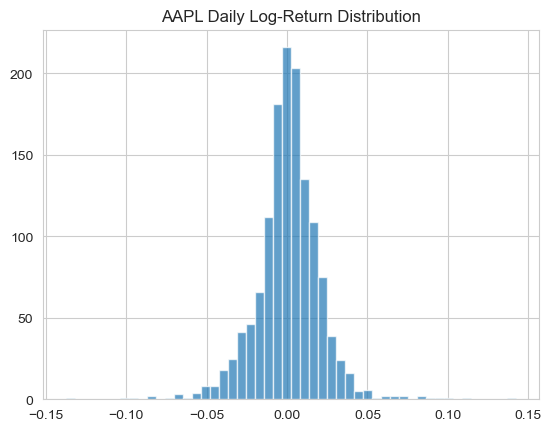

In [42]:
logR['AAPL'].hist(bins=50, alpha=0.7)
plt.title('AAPL Daily Log-Return Distribution')
plt.show()

In [47]:
summary = pd.DataFrame({
    'Mean':    logR.mean(),
    'Variance':logR.var(),
    'Skewness':logR.skew(),
    'Kurtosis':logR.kurtosis()
})
summary


,Mean,Variance,Skewness,Kurtosis
AAPL,0.000755,0.000424,0.018513,6.226409
MSFT,0.000811,0.000371,-0.165128,7.456874
GOOGL,0.000655,0.000430,-0.223692,3.638210
AMZN,0.000568,0.000522,-0.069621,4.180882


In [49]:
mu_norm, sigma_norm = logR.stack().mean(), logR.stack().std(ddof=1)
# 95% CI for mean under Normal: μ ± z*·σ/√N
N = logR.size
z95 = stats.norm.ppf(0.975)
ci_mu_norm = (mu_norm - z95*sigma_norm/np.sqrt(N),
              mu_norm + z95*sigma_norm/np.sqrt(N))


# 95% CI for σ via Chi-square:
df = N-1
chi2_low, chi2_high = stats.chi2.ppf([0.025,0.975], df)
ci_sigma_norm = (sigma_norm*np.sqrt(df/chi2_high),
                 sigma_norm*np.sqrt(df/chi2_low))

print("Normal fit:")
print(f"  μ = {mu_norm:.5f}, 95% CI {ci_mu_norm}") ## confidence interval
print(f"  σ = {sigma_norm:.5f}, 95% CI {ci_sigma_norm}")

Normal fit:
  μ = 0.00070, 95% CI (0.00014229187543832688, 0.001252144975145959)
  σ = 0.02089, 95% CI (0.020505253822907493, 0.02129036800048174)


In [51]:
returns_flat = logR.stack().values
df_t, mu_t, sigma_t = stats.t.fit(returns_flat)

In [53]:
print(mu_t)

0.001042908648841414


In [55]:
B = 1000
estimates = np.array([stats.t.fit(np.random.choice(returns_flat, size=N, replace=True))
                      for _ in range(B)])
ci_mu_t    = np.percentile(estimates[:,1], [2.5,97.5])
ci_sigma_t = np.percentile(estimates[:,2], [2.5,97.5])

In [56]:
print("\nStudent’s t fit:")
print(f"  df = {df_t:.1f}, μ = {mu_t:.5f},  σ = {sigma_t:.5f}")
print(f"  95% CI for μ (bootstrap): {ci_mu_t}")
print(f"  95% CI for σ (bootstrap): {ci_sigma_t}")


Student’s t fit:
  df = 3.7, μ = 0.00104,  σ = 0.01444
  95% CI for μ (bootstrap): [0.00055054 0.0014863 ]
  95% CI for σ (bootstrap): [0.01391873 0.01492712]


#### VAR With Normal dist

In [58]:
portR= logR.dot(weights)

In [59]:
portR

2020-01-03   -0.009888
2020-01-06    0.012885
2020-01-07   -0.003453
2020-01-08    0.007801
2020-01-09    0.012131
                ...   
2025-05-28   -0.003916
2025-05-29    0.000601
2025-05-30    0.001022
2025-06-02   -0.000056
2025-06-03   -0.002912
Length: 1361, dtype: float64

In [60]:
μ_p = portR.mean()
σ_p = portR.std(ddof=1)

In [61]:
z05= stats.norm.ppf(0.05)

In [62]:
VAR_norm= -(μ_p + σ_p *z05)

In [63]:
print(VAR_norm)

0.029131521209719874


## Using Student-t distribution

In [65]:
t05 = stats.t.ppf(0.05,df_t)

In [66]:
VaR_t = -(mu_t + sigma_t *t05) *1

In [67]:
VaR_t


0.0306075294746394

## HISTORICAL METHOD

In [69]:
hist_var = -np.percentile(portR,5)

In [70]:
print("1-Day 95% VaR:")
print(f"  Parametric (Normal):       {VAR_norm:.5f}")
print(f"  Parametric (Student’s t):  {VaR_t:.5f}")
print(f"  Historical (5th percentile): {hist_var:.5f}")

1-Day 95% VaR:
  Parametric (Normal):       0.02913
  Parametric (Student’s t):  0.03061
  Historical (5th percentile): 0.02892


#### Hypothesis Test

In [84]:
t_stat, p_val = stats.ttest_1samp(portR, 0.0)

In [86]:
print("One-sample t-test on portfolio daily returns:")
print(f"  t-statistic = {t_stat:.3f},  p-value = {p_val:.3f}")

One-sample t-test on portfolio daily returns:
  t-statistic = 1.418,  p-value = 0.156


In [88]:
if p_val < 0.05:
    print("  → Reject H0: mean return is significantly different from zero.")
else:
    print("  → Fail to reject H0: no evidence mean return ≠ 0.")

  → Fail to reject H0: no evidence mean return ≠ 0.


Corelation matrix

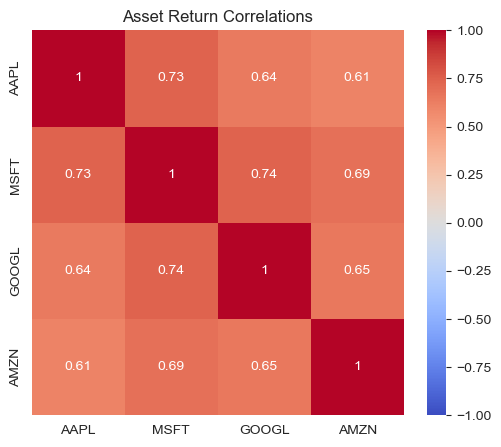

Weighted avg σ: 0.0209
Actual portfolio σ: 0.0181
Diversification benefit: 0.0027


In [93]:
import seaborn as sns

# a) Correlation heatmap
corr = logR.corr()
plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Asset Return Correlations')
plt.show()


# b) Diversification benefit
σ_i = logR.std()                         # individual volatilities
σ_weighted = np.dot(weights, σ_i)        # naive weighted avg
σ_portfolio = σ_p                        # from earlier
print(f"Weighted avg σ: {σ_weighted:.4f}")
print(f"Actual portfolio σ: {σ_portfolio:.4f}")
print(f"Diversification benefit: {σ_weighted-σ_portfolio:.4f}")

#### MDD/ DD

In [98]:
cum_ret = (price / price.iloc[0]).prod(axis=1)  # cumulative portfolio growth?
# Actually for portfolio: cum_port = (portR + 1).cumprod()
cum_port = (portR + 1).cumprod()

In [100]:
cum_port

2020-01-03    0.990112
2020-01-06    1.002869
2020-01-07    0.999406
2020-01-08    1.007203
2020-01-09    1.019421
                ...   
2025-05-28    2.066458
2025-05-29    2.067701
2025-05-30    2.069814
2025-06-02    2.069698
2025-06-03    2.063671
Length: 1361, dtype: float64

In [102]:
rolling_max = cum_port.cummax()

In [104]:
rolling_max
drawdown   = (cum_port - rolling_max) / rolling_max

In [106]:
max_dd = drawdown.min()
end_date = drawdown.idxmin()
start_date = cum_port[:end_date].idxmax()

In [108]:
print(f"Max Drawdown: {max_dd:.2%}")
print(f"From {start_date.date()} to {end_date.date()}")

Max Drawdown: -43.98%
From 2021-12-10 to 2023-01-05


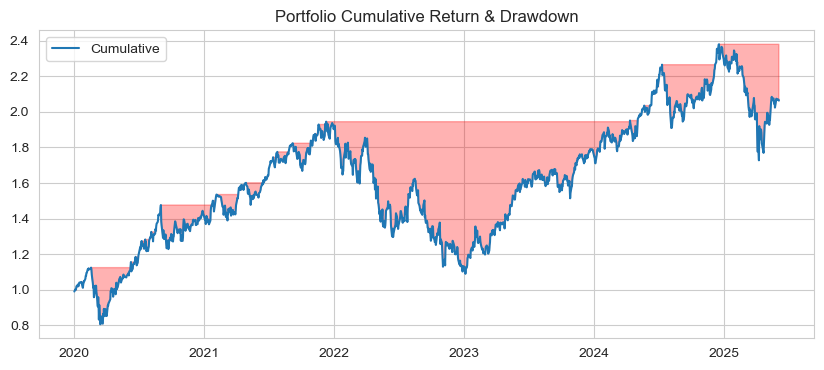

In [110]:
plt.figure(figsize=(10,4))
plt.plot(cum_port, label='Cumulative')
plt.fill_between(drawdown.index, cum_port, rolling_max,
                 where=drawdown<0, color='red', alpha=0.3)
plt.title('Portfolio Cumulative Return & Drawdown')
plt.legend()
plt.show()

### Expected shortfall / CVAR

In [113]:
alpha = 0.5 ##  ES at beyond 95%
# historical
ES_historical = portR[portR <= np.percentile(portR, 5)].mean()

# normal method
ES_norm = (μ_p - σ_p * stats.norm.pdf(z05) / alpha)

print(f"Historical ES (95%): {ES_historical:.5f}")
print(f"Parametric Normal ES (95%): {ES_norm:.5f}")

Historical ES (95%): -0.04211
Parametric Normal ES (95%): -0.00304


### "VAR Backtesting"

In [116]:
var_series= (portR.rolling(1).mean()  + portR.rolling(1).std()*z05)
### i am taking normal dist VAR
exc= portR <- VAR_norm
num_exc= exc.sum()

total =  len(portR)


print(f"Exceptions: {num_exc}/{total} days ({num_exc/total:.2%}, expected ~5%)")

Exceptions: 67/1361 days (4.92%, expected ~5%)


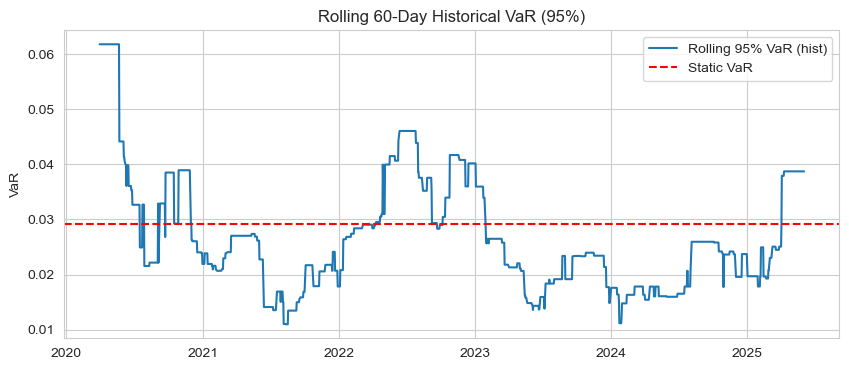

In [118]:

window = 60
roll_var = portR.rolling(window).quantile(0.05).dropna()
plt.figure(figsize=(10,4))
plt.plot(-roll_var, label='Rolling 95% VaR (hist)')
plt.axhline(VAR_norm, color='red', linestyle='--', label='Static VaR')
plt.title('Rolling 60-Day Historical VaR (95%)')
plt.ylabel('VaR')
plt.legend()
plt.show()

In [120]:
jb_stat, jb_p = stats.jarque_bera(portR)
print(f"JB statistic = {jb_stat:.2f}, p-value = {jb_p:.3f}")
if jb_p < 0.05:
    print("Reject normality at 5% level.")
else:
    print("Cannot reject normality.")

JB statistic = 1203.54, p-value = 0.000
Reject normality at 5% level.
